<a href="https://colab.research.google.com/github/joony0512/short_codes/blob/main/pytorch_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# mnist fashion data로 전체 precess

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:02<00:00, 12296508.44it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 212131.92it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3862738.93it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8238182.75it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [14]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

In [23]:
print(len(train_dataloader))
print(len(train_dataloader.dataset)/batch_size)
print(100%100)

938
937.5
0


In [25]:
for X, y in test_dataloader:
    print(X.shape)
    print(y, y.shape, y.dtype)
    break


torch.Size([64, 1, 28, 28])
tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1,
        2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5]) torch.Size([64]) torch.int64


In [7]:
!ls -al


total 20
drwxr-xr-x 1 root root 4096 Jan 14 07:38 .
drwxr-xr-x 1 root root 4096 Jan 14 07:36 ..
drwxr-xr-x 4 root root 4096 Jan 11 17:01 .config
drwxr-xr-x 3 root root 4096 Jan 14 07:38 data
drwxr-xr-x 1 root root 4096 Jan 11 17:02 sample_data


In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f'using {device} device')

using cuda device


In [31]:
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 10)
    )
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return  logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

In [16]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch % 100 ==0:
      loss, current = loss.item(), (batch +1) * len(X)
      print(f'loss : {loss :>7f} [{current :>5d} / {size:>5d}]')

In [26]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()


  test_loss /= num_batches
  correct /= size
  print(f'test error : \n Accuracy : {(100*correct):>0.1}%, Avg loss = {test_loss :8f} \n')



In [32]:
epochs = 5

for t in range(epochs):
  print(f'Epoch {t+1}\n-----------------------')
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-----------------------
loss : 2.304349 [   64 / 60000]
loss : 2.305857 [ 6464 / 60000]
loss : 2.307846 [12864 / 60000]
loss : 2.302518 [19264 / 60000]
loss : 2.309113 [25664 / 60000]
loss : 2.303407 [32064 / 60000]
loss : 2.308402 [38464 / 60000]
loss : 2.305470 [44864 / 60000]
loss : 2.300250 [51264 / 60000]
loss : 2.293892 [57664 / 60000]
test error : 
 Accuracy : 1e+01%, Avg loss = 2.305131 

Epoch 2
-----------------------
loss : 2.317039 [   64 / 60000]
loss : 2.304301 [ 6464 / 60000]
loss : 2.301216 [12864 / 60000]
loss : 2.311356 [19264 / 60000]
loss : 2.311881 [25664 / 60000]
loss : 2.301802 [32064 / 60000]
loss : 2.310298 [38464 / 60000]
loss : 2.297364 [44864 / 60000]
loss : 2.302684 [51264 / 60000]
loss : 2.299112 [57664 / 60000]
test error : 
 Accuracy : 1e+01%, Avg loss = 2.305131 

Epoch 3
-----------------------
loss : 2.297832 [   64 / 60000]
loss : 2.300636 [ 6464 / 60000]
loss : 2.297963 [12864 / 60000]
loss : 2.302392 [19264 / 60000]
loss : 2.304368 [25664 /

In [33]:
torch.save(model.state_dict(), 'model.pth')

In [34]:
!ls


data  model.pth  sample_data


In [36]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load('./model.pth'))

<All keys matched successfully>

In [37]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [41]:
test_dataloader

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [42]:
model.eval()
x, y = test_data[0][0], test_data[0][1]


with torch.no_grad():
  x = x.to(device)
  pred = model(x)
  print(pred)
  predicted, actual = classes[pred[0].argmax(0)], classes[y]
  print(f'Predicted : "{predicted}", Actual: "{actual}"')


tensor([[-0.0123, -0.0573,  0.0377,  0.0391,  0.0016, -0.0672,  0.0077,  0.0176,
          0.0004, -0.0419]], device='cuda:0')
Predicted : "Dress", Actual: "Ankle boot"


In [47]:
pred[0].argmax(0)

tensor(3, device='cuda:0')

In [68]:
model.eval()
test_loss, correct = 0, 0
with torch.no_grad():
    for X, y in test_dataloader:
      X, y = X.to(device), y
      pred = model(X)
      # print(pred.shape)
      # print(pred.argmax(1))
      break

    for i, p in enumerate(pred.argmax(1)):
        # print(p.type(torch.float))
        predicted, actual = classes[p], classes[y[i]]
        print(f'Predicted : "{predicted}", Actual: "{actual}", index: {i}')
        # break


Predicted : "Dress", Actual: "Ankle boot", index: 0
Predicted : "Pullover", Actual: "Pullover", index: 1
Predicted : "Dress", Actual: "Trouser", index: 2
Predicted : "Sneaker", Actual: "Trouser", index: 3
Predicted : "Pullover", Actual: "Shirt", index: 4
Predicted : "Pullover", Actual: "Trouser", index: 5
Predicted : "Dress", Actual: "Coat", index: 6
Predicted : "Dress", Actual: "Shirt", index: 7
Predicted : "Dress", Actual: "Sandal", index: 8
Predicted : "Sneaker", Actual: "Sneaker", index: 9
Predicted : "Pullover", Actual: "Coat", index: 10
Predicted : "Dress", Actual: "Sandal", index: 11
Predicted : "Dress", Actual: "Sneaker", index: 12
Predicted : "Pullover", Actual: "Dress", index: 13
Predicted : "Sneaker", Actual: "Coat", index: 14
Predicted : "Pullover", Actual: "Trouser", index: 15
Predicted : "Pullover", Actual: "Pullover", index: 16
Predicted : "Pullover", Actual: "Coat", index: 17
Predicted : "Pullover", Actual: "Bag", index: 18
Predicted : "Pullover", Actual: "T-shirt/top",

# tensor


In [69]:
import torch
import numpy as np

In [72]:
data = [[1,2], [3,4]]
print(data)

x_data = torch.tensor(data)
print(x_data)

[[1, 2], [3, 4]]
tensor([[1, 2],
        [3, 4]])


In [77]:
np_array = np.array(data)
print(np_array)

x_np = torch.from_numpy(np_array)
print(x_np)


[[1 2]
 [3 4]]
tensor([[1, 2],
        [3, 4]])


In [79]:
x_ones = torch.ones_like(x_data)
print(x_ones)

x_rand = torch.rand_like(x_data, dtype = torch.float)
print(x_rand)

tensor([[1, 1],
        [1, 1]])
tensor([[0.5590, 0.0225],
        [0.2223, 0.9113]])


In [86]:
shape = (2, 3, )
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(rand_tensor.shape)
print(ones_tensor)
print(zeros_tensor)

torch.Size([2, 3])
tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [88]:
tensor = torch.rand(3,4)

print(tensor.shape)
print(tensor.dtype)
print(tensor.device)

torch.Size([3, 4])
torch.float32
cpu


In [89]:
if torch.cuda.is_available():
  tensor = tensor.to("cuda")
  print(tensor.device)

cuda:0


In [118]:
tensor = torch.rand(4,4)
print('all',tensor)
print('first row',tensor[0])
print('first row',tensor[0,:])
print('first column',tensor[:,0])
print('last column',tensor[:,-1])
print('last colums', tensor[...,-1])

tensor[..., 1] = 0
print(tensor)

all tensor([[0.5209, 0.3151, 0.9661, 0.2932],
        [0.2839, 0.8323, 0.9924, 0.8368],
        [0.7608, 0.6754, 0.5918, 0.9289],
        [0.3472, 0.8185, 0.0969, 0.7305]])
first row tensor([0.5209, 0.3151, 0.9661, 0.2932])
first row tensor([0.5209, 0.3151, 0.9661, 0.2932])
first column tensor([0.5209, 0.2839, 0.7608, 0.3472])
last column tensor([0.2932, 0.8368, 0.9289, 0.7305])
last colums tensor([0.2932, 0.8368, 0.9289, 0.7305])
tensor([[0.5209, 0.0000, 0.9661, 0.2932],
        [0.2839, 0.0000, 0.9924, 0.8368],
        [0.7608, 0.0000, 0.5918, 0.9289],
        [0.3472, 0.0000, 0.0969, 0.7305]])


In [122]:
tensor = torch.ones(4,4)
tensor[:, 1] = 0
t1 = torch.cat([tensor, tensor, tensor], dim =0)
print(t1, t1.shape)

tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]]) torch.Size([12, 4])


In [130]:
y1 = tensor @ tensor.T
print(y1)
y2 = tensor.matmul(tensor.T)
print(y2)
y3 = torch.rand_like(y1)
print(y3)
torch.matmul(tensor, tensor.T, out=y3)
print(y3)

tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])
tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])
tensor([[0.5084, 0.0396, 0.0902, 0.3994],
        [0.5616, 0.4215, 0.2935, 0.4037],
        [0.8990, 0.4171, 0.4273, 0.5917],
        [0.4263, 0.2929, 0.0901, 0.1853]])
tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])
tensor([[3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.],
        [3., 3., 3., 3.]])


In [128]:
z1 = tensor[0]*tensor[0]
print(z1)

z2 = tensor.mul(tensor)
print(z2)

z3 = torch.rand_like(tensor)
torch.mul(tensor, tensor, out= z3)
print(z3)

tensor([1., 0., 1., 1.])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])
tensor([[1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.],
        [1., 0., 1., 1.]])


In [139]:
tensor = torch.ones(4,4,4)
agg = tensor.sum()
agg_item = agg.item()
print(agg,agg_item, type(agg_item))

tensor(64.) 64.0 <class 'float'>


In [140]:
print(tensor)

tensor+=5 # tensor.add_(5)
print(tensor)

tensor([[[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]],

        [[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]])
tensor([[[6., 6., 6., 6.],
         [6., 6., 6., 6.],
         [6., 6., 6., 6.],
         [6., 6., 6., 6.]],

        [[6., 6., 6., 6.],
         [6., 6., 6., 6.],
         [6., 6., 6., 6.],
         [6., 6., 6., 6.]],

        [[6., 6., 6., 6.],
         [6., 6., 6., 6.],
         [6., 6., 6., 6.],
         [6., 6., 6., 6.]],

        [[6., 6., 6., 6.],
         [6., 6., 6., 6.],
         [6., 6., 6., 6.],
         [6., 6., 6., 6.]]])


In [144]:
t = torch.ones(5)
print(t, t.dtype)

n = t.numpy()
print(n, n.dtype)

tensor([1., 1., 1., 1., 1.]) torch.float32
[1. 1. 1. 1. 1.] float32


In [146]:
t.add_(1)
print(t)
print(n)

tensor([3., 3., 3., 3., 3.])
[3. 3. 3. 3. 3.]


In [157]:
n = np.ones((5,5))
print(n)
t = torch.from_numpy(n)
print(t)

[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], dtype=torch.float64)


In [159]:
np.add(n, 1, out = n)
print(t)
print(n)

tensor([[2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.],
        [2., 2., 2., 2., 2.]], dtype=torch.float64)
[[2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2.]]


# Datasets & Dataloaders

In [161]:
import torch
from torch.utils.data import  Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

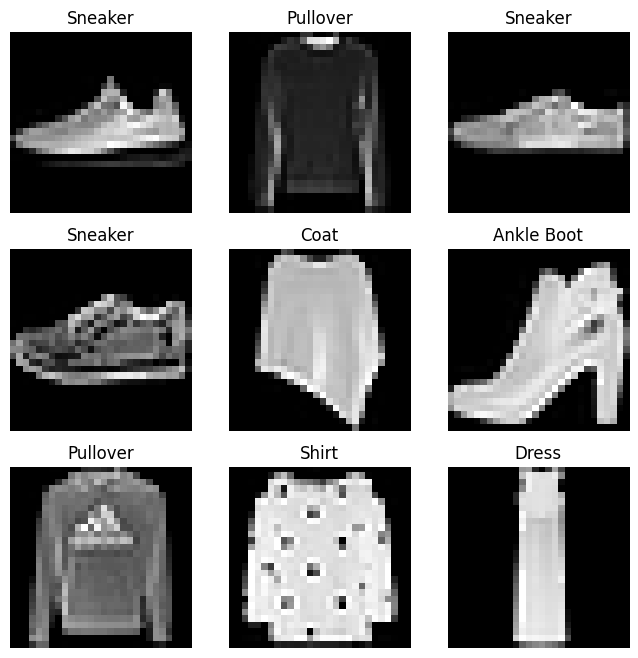

In [163]:
fig = plt.figure(figsize = (8,8))
cols, rows = 3,3
for i in range(1, cols*rows +1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  fig.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap ='gray')
plt.show()

# Create a Custom dataset for your files

In [164]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform = None, target_transform = None):
    self.img_labels = pd.read(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)
  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]

    if self.transform :
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label

In [165]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size = batch_size , shuffle =True)
test_dataloader = DataLoader(test_data, batch_size = batch_size , shuffle =True)



In [170]:
train_images, train_labels = next(iter(train_dataloader))
print(f'image batch size : {train_images.size()}')
print(f'image batch size : {train_images.shape}')
print(f'label batch size : {train_labels.size()}')

image batch size : torch.Size([64, 1, 28, 28])
image batch size : torch.Size([64, 1, 28, 28])
label batch size : torch.Size([64])


In [171]:
print(train_images[0].shape)
img = train_images[0].squeeze()
print(img.shape)

torch.Size([1, 28, 28])
torch.Size([28, 28])


image batch size : torch.Size([64, 1, 28, 28])
label batch size : torch.Size([64])


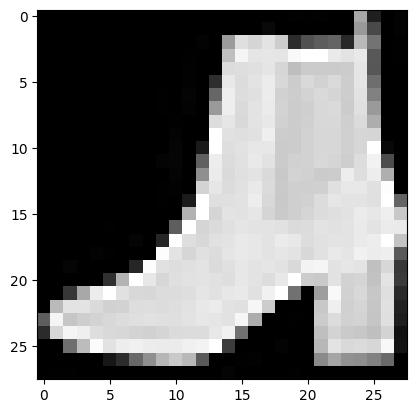

label:9, label_name:Ankle boot


In [173]:
train_images, train_labels = next(iter(train_dataloader))

print(f'image batch size : {train_images.size()}')
print(f'label batch size : {train_labels.size()}')

img = train_images[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap = 'gray')
plt.show()
print(f'label:{label}, label_name:{classes[label]}')